In [1]:
!pip install tweepy
!pip install transformers
!pip install torch

In [2]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 6.8 MB/s eta 0:00:00


In [4]:
import tweepy
import os.path as path
import numpy as np
import nltk.tokenize as tk
import math
import scipy.stats as stats
import pandas as pd
import huggingface_hub
from scipy.stats import pearsonr
from transformers import AutoTokenizer
from transformers import AutoModelForMaskedLM
import torch
from transformers import BertModel
import sklearn.cluster
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import emoji


In [5]:
def get_all_examples():
    """Load all examples from a CSV file using pandas and return those that contain text.

    Returns:
        A list of tweets (or data) that contain text.
    """
    save_file = './twitter_emoji.csv'

    if path.exists(save_file):
        df = pd.read_csv(save_file, lineterminator = '\n')
        ids_to_examples = df[df['Text'].notna()].to_dict(orient='records')  # Convert to list of dicts
    else:
        print('Could not find tweets, so returning an empty list!')
        ids_to_examples = []

    return ids_to_examples


def get_emojis_in_tweet(tweet, emojis, tokenizer):
    """Get a list of all the emojis in a tweet based on the sets provided

    Args:
        tweet: Tweet
        tokenizer: NLTK tokenizer

    Returns:
        Emojis in a tweet
    """
    tokens = tokenizer.tokenize(tweet['Text'])
    ems = set()
    for token in tokens:
        if token in emojis:
            ems.add(token)
    return ems


def get_tweets_with_emoji(tweets, emojis):
    """Get all tweets with emoji in the sets

    Args:
        tweets: List of Tweets

    Returns:
        All tweets containing emoji

    """
    tokenizer = tk.TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    ems = list()
    for tweet in tweets:
        if get_emojis_in_tweet(tweet, emojis, tokenizer):
            ems.append(tweet)
    return ems


In [11]:
target_emoji = "😭"
emojis = [target_emoji]


# tweets = get_all_examples()
# tweetsWithEmoji = get_tweets_with_emoji(tweets, [target_emoji])
# emojis = []
# for tweet in tweetsWithEmoji:
#     line = tweet["Text"]
#     for em in emoji.emoji_list(line):
#         emojis.append(em["emoji"])

checkpoint = 'bert-base-uncased'

model = AutoModelForMaskedLM.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenizer.add_tokens(emojis)
model.resize_token_embeddings(len(tokenizer))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Embedding(30523, 768, padding_idx=0)

In [12]:
tweets = get_all_examples()
tweetsWithEmoji = get_tweets_with_emoji(tweets, [target_emoji])
lines = []
for tweet in tweetsWithEmoji:
    line = tweet["Text"]
    for em in emoji.emoji_list(line):
        em = em["emoji"]
        line = line.replace(em, " " + em + " ")
    line = line.replace("  ", " ")
    lines.append(line)


print(len(lines))
print(lines[0:4])

182
['OMG Finally SUGA showed off his 7 tattoo in the latest single People pt.2 (feat IU) by Agust D MV. 😭 😍 💜 🫂 \n\nTo see 👉 https://t.co/02PIewjj7o https://t.co/bHDVBQ7zqo', '@hiyyihsolo @PyrrahTale Oh they’re obsessed with hiyyihligths wtf 💀 😭 , it’s so fcking weird 🧍🏻 ', "@CalvinKlein Can we have more denim jackets for ladies? 👉 👈 The men's jackets selection is so much better, but I don't want men's jacket 😭 ", "@Thewrightbros89 damn right  😭  we're on this together  😭  chatkhem era coming soon 👉 💛 "]


In [13]:
# and adapting the other function
def combined_vector_for(targetword, text, bert_input, bert_output,
                        layer = -1, word_occurrence = 0):
    """
    calculate a word vector
    based on the mean of the WordPiece vectors in the given layer.
    targetword is a word appearing in text.
    bert_input is the whole dictionary returned by the tokenizer.
    bert_output is the last-layer output obtained
    on this text.
    """
    tokenized_text = [w for w, n in tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text)]

    # where in the tokenized text (split into words but not split into word pieces)
    # do we find the target word?
    target_word_indices = [i for i, x in enumerate(tokenized_text) if x == targetword]

    # sanity check
    if len(target_word_indices) < word_occurrence + 1:
        # no occurrences found, or not enough to match the required one
        print("Target Word Not Found")
        return None

    # if multiple occurrences of the target word, we use this one
    usethis_targetword_index = target_word_indices[ word_occurrence]

    # use word_to_tokens to determine the word piece span of the target word
    word_start, word_end = bert_input.word_to_tokens( usethis_targetword_index )

    # extract the embeddings from the right layer, and the target vectors from that layer
    embeddings= bert_output["hidden_states"][layer]
    # print(embeddings.shape)
    target_vectors = embeddings[0, word_start:word_end, :]

    # if we have multiple word pieces for ti'his word, average over them
    avg_target_vector = target_vectors.mean(dim = 0)

    return avg_target_vector.detach().numpy()



In [15]:
embeddings = []
# checkpoint = 'bert-base-uncased'
for line in lines:

    text = line

    bert_inputs = tokenizer(text, padding=True, truncation=True,  return_tensors="pt")

    tokens = tokenizer.tokenize(text, add_special_tokens = True)
    # print(tokens)
    # print(tokenizer.backend_tokenizer.pre_tokenizer.pre_tokenize_str(text))

    bert_output = model(bert_inputs["input_ids"], output_hidden_states = True)

    charge_output = combined_vector_for(target_emoji, text, bert_inputs, bert_output, layer = 7, word_occurrence = 0)
    # print(text)
    # print("-------------")

    embeddings.append(charge_output)

print(len(embeddings))
# print(embeddings)


182


In [16]:
# print(embeddings)

In [17]:
embeddings = [x for x in embeddings if x is not None]
print(len(embeddings))

182


In [18]:
kmeans = sklearn.cluster.KMeans(n_clusters=5, random_state=2048).fit(embeddings)
#random_state makes clustering deterministic - it's a seed value

In [19]:
cluster_list = kmeans.predict(embeddings)
print(len(list(cluster_list)))
print((list(cluster_list)))

182
[2, 0, 3, 1, 1, 4, 3, 0, 2, 1, 0, 0, 2, 4, 2, 2, 2, 3, 4, 4, 0, 3, 1, 2, 2, 2, 1, 0, 2, 1, 2, 1, 2, 4, 2, 1, 2, 1, 4, 2, 1, 0, 2, 2, 4, 4, 4, 0, 3, 2, 0, 3, 4, 2, 0, 2, 2, 2, 2, 3, 3, 0, 2, 2, 3, 1, 4, 4, 3, 3, 2, 1, 2, 2, 1, 2, 3, 1, 3, 2, 0, 0, 0, 3, 0, 0, 2, 4, 1, 0, 4, 0, 2, 3, 1, 4, 4, 4, 3, 2, 2, 0, 2, 4, 2, 1, 0, 0, 1, 3, 4, 3, 0, 4, 4, 4, 2, 4, 1, 2, 3, 4, 3, 2, 2, 1, 2, 0, 2, 0, 0, 1, 2, 0, 1, 4, 2, 2, 0, 1, 2, 4, 1, 3, 2, 4, 2, 1, 2, 1, 2, 2, 0, 4, 2, 0, 2, 2, 1, 2, 4, 0, 2, 2, 2, 2, 1, 2, 2, 2, 4, 4, 2, 2, 1, 2, 4, 0, 3, 2, 0, 0]


In [20]:
cluster_dict = {0:[],1:[],2:[],3:[],4:[]}
for i in range(len(cluster_list)):
  cluster_dict[cluster_list[i]].append(i)

In [21]:
outs = 3
random.seed(50)

for cluster in cluster_dict.keys():
  sents = random.sample(cluster_dict[cluster],1)
  for sent in sents:
    print(lines[sent])

  print()

@pachtaogaybro Na nah simping is crazy tho 😭  😭  but I'm on it 👉 👈 .

 ☠️ AIR POLLUTION by oil giants continues to trap impoverished communities into generations of INJUSTICE. 

Of concern is the evidence for neurocognitive effects related to exposure to pollutants on children. 😭  

 💪 Help put an end to this here 👉 https://t.co/8jzCkVZ5OV https://t.co/aTc6Rz4TtB

Why is this the Hyuka piic when you google 'txt members' 😭 https://t.co/cq66wwZOuy

@AkaruAD Our power is out too 😭 

THIS DOESNT WORK WITH RENGA cus reki thinks langa is everything and langa thinks reki is everything.. they’re both everything to each other im going to cry and  😭  😭  👉    💔      💔      💔      💔      💔      💔   



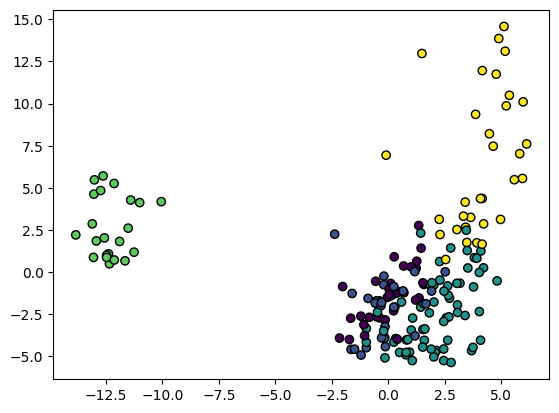

In [22]:
twodim = PCA().fit_transform(embeddings)[:,:2]

# set up the canvas
fig, ax =  plt.subplots()

# add a scatter plot of the two-D embeddings
scatter = ax.scatter(twodim[:,0], twodim[:,1], edgecolors='k', c=cluster_list)

# and show the canvas
plt.show()